In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
import logging
import numpy as np
import methods
import torch as th
from skimage.util import random_noise
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm
import albumentations as A

from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [2]:
#Load data and plot
DATASET_DIR = "/home/erdem/dataset/patches_urine_32_scaled"
CATEGORIES_ALL = ["Artifact", "BC", "cCry", "Dirt", "hCast", "LD", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "Unclassified", "WBC"]
CATEGORIES_INLIER = ["BC", "cCry", "hCast", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "WBC"]
CATEGORIES_OUTLIER = ["Artifact", "Dirt", "LD"]

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, rotate_limit=90, scale_limit=[0,0.3], always_apply=True, p=1)
])

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC"]
dim = (32, 32)
height, width = dim
transformed_cCry = methods.getTransformedImages("cCry", dim, transform, 200)
transformed_sCry = methods.getTransformedImages("sCry", dim, transform, 40)
transformed_uCry = methods.getTransformedImages("uCry", dim, transform, 40)
transformed_hCast = methods.getTransformedImages("hCast", dim, transform, 200)
transformed_nhCast = methods.getTransformedImages("nhCast", dim, transform, 200)
transformed_nsEC = methods.getTransformedImages("nsEC", dim, transform, 20)
transformed_sEC = methods.getTransformedImages("sEC", dim, transform, 20)
transformed_WBC = methods.getTransformedImages("WBC", dim, transform, 10)
transformed_RBC = methods.getTransformedImages("RBC", dim, transform, 10)
transformed_BC = methods.getTransformedImages("BC", dim, transform, 4)

transformed_all = np.concatenate((transformed_cCry, transformed_sCry, transformed_uCry, transformed_hCast, 
                                 transformed_nhCast, transformed_nsEC, transformed_sEC, transformed_WBC,
                                 transformed_RBC, transformed_BC))

testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers_loop = [testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC]
X_outliers_loop = [testImages_Artifact, testImages_Dirt, testImages_LD]

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [3]:
inlier_dataset = []
outlier_dataset = []

def createInlierData():
    for category in CATEGORIES_INLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                inlier_dataset.append(img_array)
            except Exception as e:
                pass

def createOutlierData():
    for category in CATEGORIES_OUTLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                outlier_dataset.append(img_array)
            except Exception as e:
                pass

In [4]:
createInlierData()
createOutlierData()

X_inlier = np.array(inlier_dataset).reshape(-1, 32, 32, 1)
X_inlier = X_inlier.astype('float32') / 255
np.random.shuffle(X_inlier)

X_outlier = np.array(outlier_dataset).reshape(-1, 32, 32, 1)
X_outlier = X_outlier.astype('float32') / 255
# np.random.shuffle(X_outlier)

X_large_inlier = transformed_all.reshape(-1, 32, 32, 1)
X_large_inlier = X_large_inlier.astype('float32')/255

print(X_inlier.shape)
print(X_outlier.shape)
print(X_large_inlier.shape)

(21416, 32, 32, 1)
(113, 32, 32, 1)
(229732, 32, 32, 1)


In [29]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [30]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 4, 4, 128)    73856       conv2d_4[0][0]                   
____________________________________________________________________________________________

In [31]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, strides=2, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              526336    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 1)         289       
Total params: 618,881
Trainable params: 618,881
Non-trainable params: 0
_____________________________________________________

In [37]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z, z_mean, z_log_var
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.1*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [38]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
history = vae.fit(X_inlier, epochs=500, batch_size=64)

Epoch 1/500
335/335 [==============================] - 4s 9ms/step - loss: 4.7484 - reconstruction_loss: 2.4286 - kl_loss: 21.2666
Epoch 2/500
335/335 [==============================] - 3s 9ms/step - loss: 4.3852 - reconstruction_loss: 2.4953 - kl_loss: 19.1495
Epoch 3/500
335/335 [==============================] - 3s 9ms/step - loss: 4.3726 - reconstruction_loss: 2.5043 - kl_loss: 18.8058
Epoch 4/500
335/335 [==============================] - 3s 9ms/step - loss: 4.4010 - reconstruction_loss: 2.5099 - kl_loss: 18.5883
Epoch 5/500
335/335 [==============================] - 3s 9ms/step - loss: 4.3814 - reconstruction_loss: 2.5127 - kl_loss: 18.4016
Epoch 6/500
335/335 [==============================] - 3s 9ms/step - loss: 4.3789 - reconstruction_loss: 2.5146 - kl_loss: 18.3172
Epoch 7/500
335/335 [==============================] - 3s 9ms/step - loss: 4.3290 - reconstruction_loss: 2.5170 - kl_loss: 18.2077
Epoch 8/500
335/335 [==============================] - 3s 9ms/step - loss: 4.3434 -

Epoch 125/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1322 - reconstruction_loss: 2.4874 - kl_loss: 16.6722
Epoch 126/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1742 - reconstruction_loss: 2.4931 - kl_loss: 16.6803
Epoch 127/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1226 - reconstruction_loss: 2.4884 - kl_loss: 16.6251
Epoch 128/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1564 - reconstruction_loss: 2.4861 - kl_loss: 16.7009
Epoch 129/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1243 - reconstruction_loss: 2.4849 - kl_loss: 16.6203
Epoch 130/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1333 - reconstruction_loss: 2.4867 - kl_loss: 16.6255
Epoch 131/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1532 - reconstruction_loss: 2.4866 - kl_loss: 16.6278
Epoch 132/500
335/335 [==============================] - 3s 9ms/step 

335/335 [==============================] - 3s 9ms/step - loss: 4.0852 - reconstruction_loss: 2.4630 - kl_loss: 16.3484
Epoch 248/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0822 - reconstruction_loss: 2.4589 - kl_loss: 16.3643
Epoch 249/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0777 - reconstruction_loss: 2.4567 - kl_loss: 16.3453
Epoch 250/500
335/335 [==============================] - 3s 9ms/step - loss: 4.1171 - reconstruction_loss: 2.4593 - kl_loss: 16.3316
Epoch 251/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0784 - reconstruction_loss: 2.4561 - kl_loss: 16.3198
Epoch 252/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0947 - reconstruction_loss: 2.4603 - kl_loss: 16.3241
Epoch 253/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0951 - reconstruction_loss: 2.4608 - kl_loss: 16.3007
Epoch 254/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0832

335/335 [==============================] - 3s 9ms/step - loss: 4.0816 - reconstruction_loss: 2.4409 - kl_loss: 16.2002
Epoch 370/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0405 - reconstruction_loss: 2.4382 - kl_loss: 16.1902
Epoch 371/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0729 - reconstruction_loss: 2.4400 - kl_loss: 16.1724
Epoch 372/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0334 - reconstruction_loss: 2.4410 - kl_loss: 16.1423
Epoch 373/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0813 - reconstruction_loss: 2.4422 - kl_loss: 16.1872
Epoch 374/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0664 - reconstruction_loss: 2.4430 - kl_loss: 16.2012
Epoch 375/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0570 - reconstruction_loss: 2.4391 - kl_loss: 16.1897
Epoch 376/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0459

335/335 [==============================] - 3s 9ms/step - loss: 4.0457 - reconstruction_loss: 2.4246 - kl_loss: 16.0820
Epoch 492/500
335/335 [==============================] - 3s 9ms/step - loss: 3.9976 - reconstruction_loss: 2.4288 - kl_loss: 16.0818
Epoch 493/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0582 - reconstruction_loss: 2.4239 - kl_loss: 16.0760
Epoch 494/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0512 - reconstruction_loss: 2.4275 - kl_loss: 16.0464
Epoch 495/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0216 - reconstruction_loss: 2.4254 - kl_loss: 16.0502
Epoch 496/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0265 - reconstruction_loss: 2.4252 - kl_loss: 16.1003
Epoch 497/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0459 - reconstruction_loss: 2.4233 - kl_loss: 16.1269
Epoch 498/500
335/335 [==============================] - 3s 9ms/step - loss: 4.0459

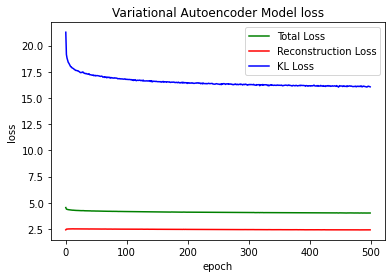

In [39]:
plt.plot(history.history['loss'], 'g', label='Total Loss')
plt.plot(history.history['reconstruction_loss'], 'r', label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], 'b', label="KL Loss")
plt.title('Variational Autoencoder Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

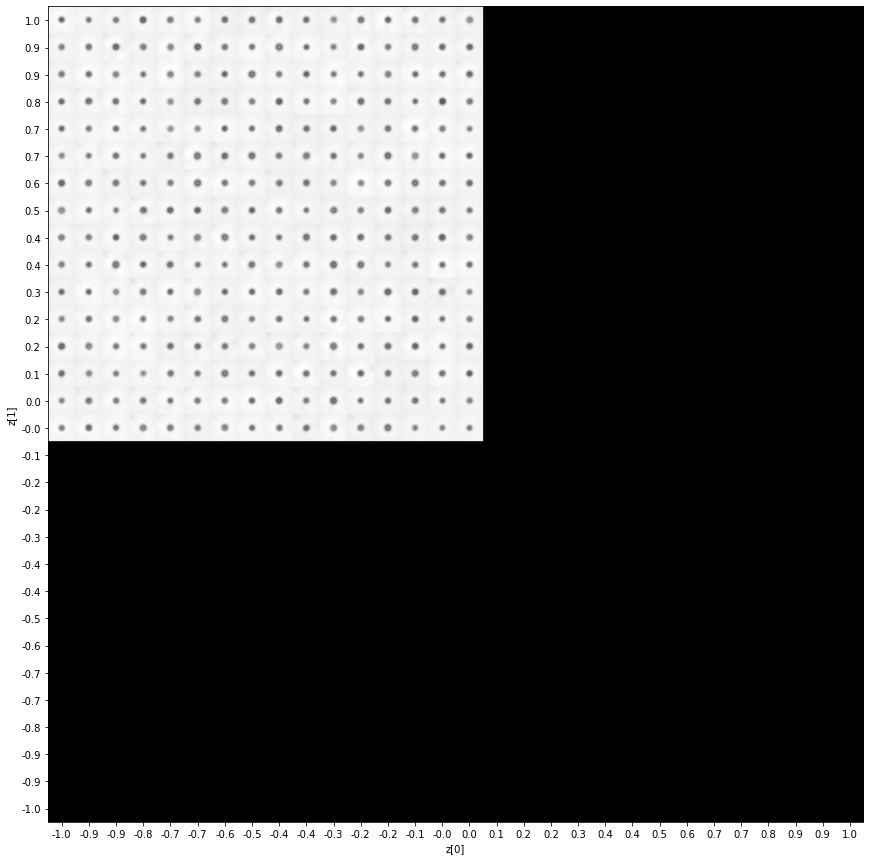

In [40]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

#     print(grid_y)
#     print(grid_x)
#     np.random.random_sample((256,))
    for i in range(16):
        for j in range(16):
            z_sample = np.random.random_sample((256,))
            x_decode = vae.decoder.predict(z_sample.reshape(1, 256))
            digit = x_decode[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
#     for i, yi in enumerate(grid_y):
#         for j, xi in enumerate(grid_x):
#             z_sample = np.array([[xi, yi]])
#             x_decoded = vae.decoder.predict(z_sample)
#             digit = x_decoded[0].reshape(digit_size, digit_size)
#             figure[
#                 i * digit_size : (i + 1) * digit_size,
#                 j * digit_size : (j + 1) * digit_size,
#             ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

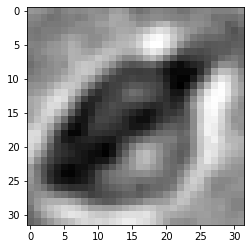

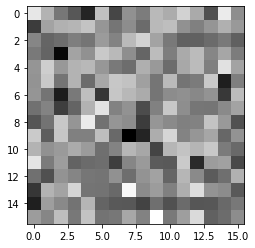

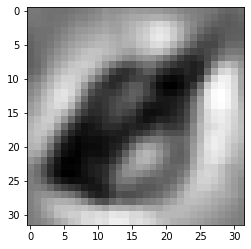

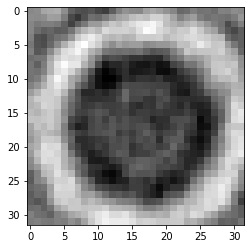

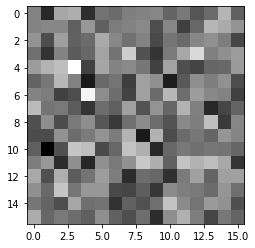

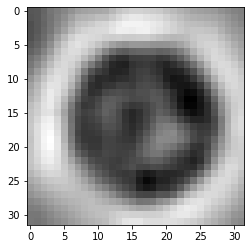

In [41]:
idx = 2094
X = X_inlier[idx].reshape(1, 32, 32, 1)
X_recon, X_z, X_z_mean, X_z_log_var = vae(X)

plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_z).reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_recon).reshape(32, 32, 1), cmap="gray")
plt.show()

idx = 10
X = X_outlier[idx].reshape(1, 32, 32, 1)
X_recon, X_z, X_z_mean, X_z_log_var = vae(X)

plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_z).reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(np.asarray(X_recon).reshape(32, 32, 1), cmap="gray")
plt.show()

In [46]:
# Model Save
path = 'vae_encoder_net'
encoder.save(path)
path = 'vae_decoder_net'
decoder.save(path)

In [93]:
path = 'vae'
vae.save(path)

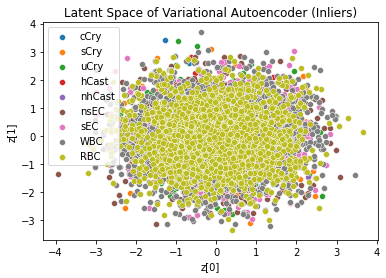

In [42]:
i = 0
for inlier in X_inliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(inlier)
    a = sns.scatterplot(x=X_z[:, 0], y=X_z[:, 1], label=inlier_names[i])
    i += 1
    plt.title('Latent Space of Variational Autoencoder (Inliers)')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')

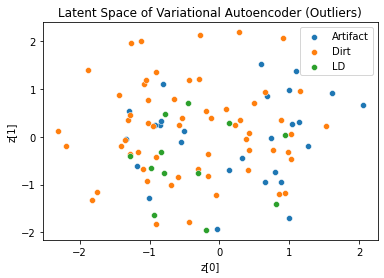

In [43]:
i = 0
for inlier in X_outliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(inlier)
    a = sns.scatterplot(x=X_z[:, 0], y=X_z[:, 1], label=CATEGORIES_OUTLIER[i])
    i += 1
    plt.title('Latent Space of Variational Autoencoder (Outliers)')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')

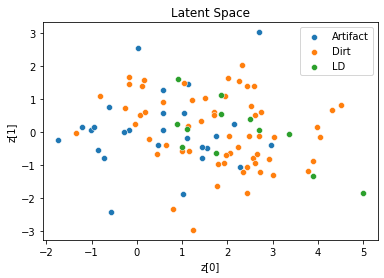

In [26]:
i = 0
for inlier in X_outliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(inlier)
    a = sns.scatterplot(x=X_z[:, 0], y=X_z[:, 1], label=CATEGORIES_OUTLIER[i])
    i += 1
    plt.title('Latent Space')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')

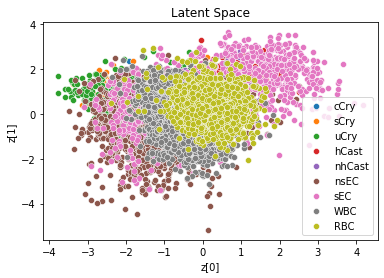

In [14]:
i = 0
for inlier in X_inliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(inlier)
    a = sns.scatterplot(x=X_z[:, 0], y=X_z[:, 1], label=inlier_names[i])
    i += 1
    plt.title('Latent Space of AE')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')

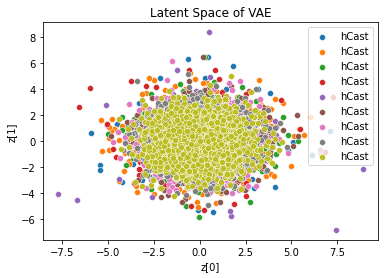

In [48]:
pca = PCA(n_components = 2)

for inlier in X_inliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(inlier)
    X_transform = pca.fit_transform(X_z)
    a = sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], label=inlier_names[i])
    plt.title('Latent Space of VAE')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')

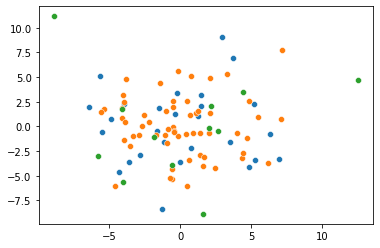

In [45]:
for outlier in X_outliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(outlier)
    X_transform = pca.fit_transform(X_z)
    a = sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1])

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)